In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import wandb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.ensemble import AdaBoostClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.mixture import GaussianMixture

import scattertext as st
import spacy

# Data visualization

In [31]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
train_raw_data = pd.read_csv('raw-data/train.csv')
test_raw_data = pd.read_csv('raw-data/test.csv')
val_raw_data = pd.read_csv('raw-data/valid.csv')

nlp = spacy.load('en_core_web_sm')

combined_data = pd.concat([train_raw_data[['requirements_and_role']], test_raw_data[['requirements_and_role']], val_raw_data[['requirements_and_role']]], ignore_index=True)

def remove_punctuation(text):
    if not isinstance(text, str):
        return ""
    no_punct = [words for words in text if words not in string.punctuation]
    words_wo_punct = ''.join(no_punct)
    return words_wo_punct

combined_data['requirements_and_role'] = combined_data['requirements_and_role'].apply(lambda x: remove_punctuation(x))

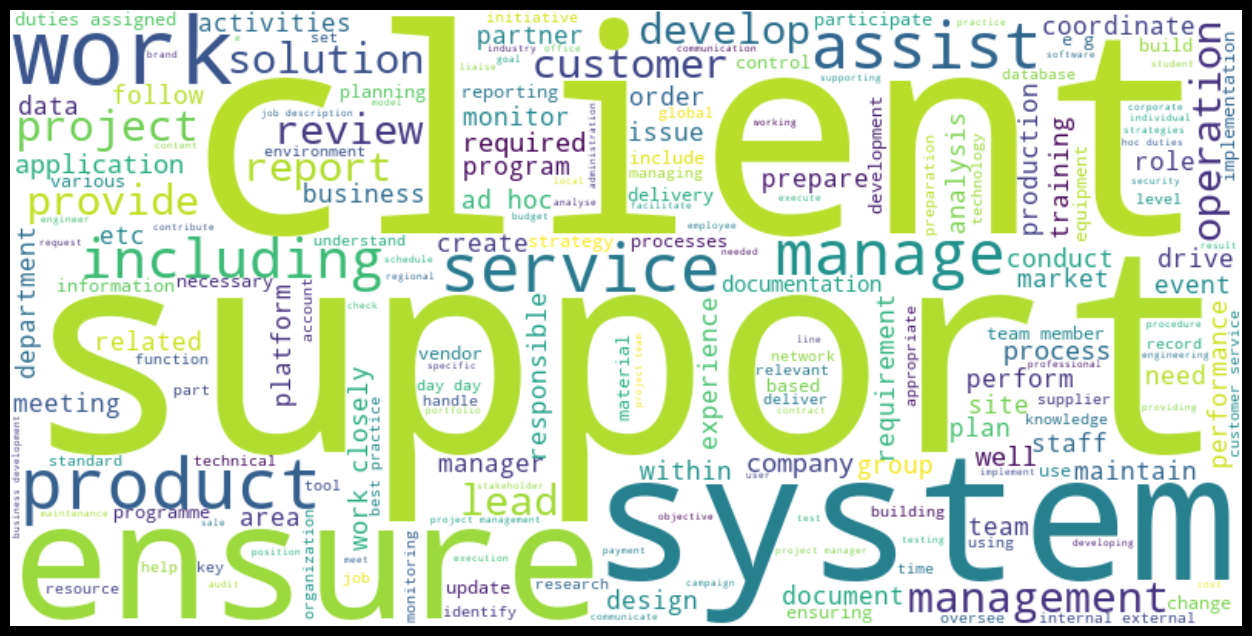

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_text = ' '.join(combined_data['requirements_and_role'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



# Data

In [6]:
def split_pd_data(data):
    label_data = data.iloc[:8000, :]
    unlabel_data = data.iloc[8000:, :]

    return label_data, unlabel_data

## Raw data

In [7]:
train_raw_data = pd.read_csv('raw-data/train.csv')
test_raw_data = pd.read_csv('raw-data/test.csv')
val_raw_data = pd.read_csv('raw-data/valid.csv')

In [8]:
train_raw_data.dtypes

job_id                    object
requirements_and_role     object
salary_bin               float64
mean_salary              float64
gender_code              float64
dtype: object

In [9]:
label_raw_data, unlabel_raw_data = split_pd_data(train_raw_data)

In [10]:
label_raw_data.shape, unlabel_raw_data.shape

((8000, 5), (5902, 5))

<AxesSubplot:>

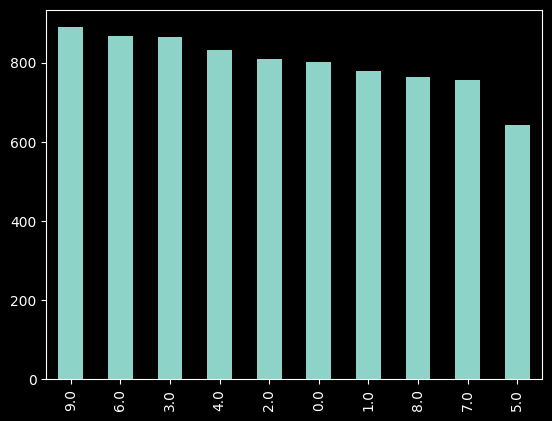

In [11]:
# plot the distribution of the labels
label_raw_data['salary_bin'].value_counts().plot(kind='bar')

## embedding data

In [12]:
def split_np_data(data):
    label_data = data[:8000, :]
    unlabel_data = data[8000:, :]

    return label_data, unlabel_data

In [13]:
train_emb_data = np.load('embeddings-data/train-embeddings.npy')
val_emb_data = np.load('embeddings-data/valid-embeddings.npy')
test_emb_data = np.load('embeddings-data/test-embeddings.npy')

In [14]:
label_emb_data, unlabel_emb_data = split_np_data(train_emb_data)

In [15]:
label_emb_data.shape, unlabel_emb_data.shape

((8000, 384), (5902, 384))

## TF-IDF data

In [16]:
train_tfidf_data = np.load('tfidf-data/train-tfidf.npy')
val_tfidf_data = np.load('tfidf-data/valid-tfidf.npy')
test_tfidf_data = np.load('tfidf-data/test-tfidf.npy')

In [17]:
label_tfidf_data, ublabel_tfidf_data = split_np_data(train_tfidf_data)

In [18]:
train_tfidf_data.shape, val_tfidf_data.shape, test_tfidf_data.shape

((13902, 500), (1737, 500), (1738, 500))

## Labeled data

### Firstly, using Labeled Embedding data

In [17]:
# define the X_train, y_train, X_test, y_test

X_train = label_emb_data
y_train = label_raw_data['salary_bin'].values
X_val = val_emb_data
y_val = val_raw_data['salary_bin'].values
labels = np.unique(y_train)

### Secondly, we test the tfidf data

In [18]:
X_train = label_tfidf_data
y_train = label_raw_data['salary_bin'].values
X_val = val_tfidf_data
y_val = val_raw_data['salary_bin'].values
labels = np.unique(y_train)

### KNN clf


In [19]:
def train_and_evaluate_knn(k, weights, p, X_train, y_train, X_test, y_test):
    # Create a kNN classifier with the given parameters
    knn_clf = KNeighborsClassifier(n_neighbors=k, weights=weights, p=p)
    
    # Train the classifier
    knn_clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = knn_clf.predict(X_test)
    
    # Calculate accuracy and other metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, report, cm


In [17]:
k_values = list(range(1, 11))
weights_options = ['uniform', 'distance']
p_values = [1, 2]  # 1 = Manhattan distance, 2 = Euclidean distance

In [18]:
# for k in k_values:
#     for weights in weights_options:
#         for p in p_values:
#             with wandb.init(project="Assignment3-tfidf", config={"k": k, "weights": weights, "p": p}, group="grid_search") as run:
#                 config = wandb.config
                
#                 # Train and evaluate the kNN classifier
#                 accuracy, report, cm = train_and_evaluate_knn(config.k, config.weights, config.p, X_train, y_train, X_val, y_val)
                
#                 # Log the results to WandB
#                 wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm})


In [19]:
# clf = KNeighborsClassifier(n_neighbors=3, weights='distance', p=2)

### Decision Tree clf

In [20]:
def train_and_evaluate_dt(criterion, splitter, max_depth, min_samples_split, min_samples_leaf, X_train, y_train, X_test, y_test):
    # Create a decision tree classifier with the given parameters
    dt_clf = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    # Train the classifier
    dt_clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = dt_clf.predict(X_test)
    
    # Calculate accuracy and other metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, report, cm

In [21]:
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [5, 10, 15]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]

In [22]:
# for c in criterion:
#     for s in splitter:
#         for d in max_depth:
#             for ss in min_samples_split:
#                 for sl in min_samples_leaf:
#                     with wandb.init(project="Assignment3-tfidf", config={"criterion": c, "splitter": s, "max_depth": d, "min_samples_split": ss, "min_samples_leaf": sl}, group="dt_grid_search") as run:
#                         config = wandb.config

#                         # Train and evaluate the decision tree classifier
#                         accuracy, report, cm = train_and_evaluate_dt(config.criterion, config.splitter, config.max_depth, config.min_samples_split, config.min_samples_leaf, X_train, y_train, X_val, y_val)

#                         # Log the results to WandB
#                         wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm})

### Gaussian Naive Bayes clf

In [23]:
def train_and_evaluate_GNB(var_smoothing, X_train, y_train, X_test, y_test):
    # Create a Gaussian Naive Bayes classifier with the given parameters
    gnb_clf = GaussianNB(var_smoothing=var_smoothing)
    
    # Train the classifier
    gnb_clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = gnb_clf.predict(X_test)
    
    # Calculate accuracy and other metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, report, cm

In [24]:
var_smoothing = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

In [25]:
# for v in var_smoothing:
#     with wandb.init(project="Assignment3-tfidf", config={"var_smoothing": v}, group="gnb_grid_search") as run:
#         config = wandb.config

#         # Train and evaluate the Gaussian Naive Bayes classifier
#         accuracy, report, cm = train_and_evaluate_GNB(config.var_smoothing, X_train, y_train, X_val, y_val)

#         # Log the results to WandB
#         wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm})

### BernoulliNB clf

In [26]:
def train_and_evaluate_BNB(alpha, binarize, X_train, y_train, X_test, y_test):
    # Create a Bernoulli Naive Bayes classifier with the given parameters
    bnb_clf = BernoulliNB(alpha=alpha, binarize=binarize)
    
    # Train the classifier
    bnb_clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = bnb_clf.predict(X_test)
    
    # Calculate accuracy and other metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, report, cm

In [27]:
alpha = [0.1, 0.5, 1.0, 1.5, 2.0]

In [28]:
# for a in alpha:
#     with wandb.init(project="Assignment3-tfidf", config={"alpha": a}, group="bnb_grid_search") as run:
#         config = wandb.config

#         # Train and evaluate the Bernoulli Naive Bayes classifier
#         accuracy, report, cm = train_and_evaluate_BNB(config.alpha, 0.0, X_train, y_train, X_val, y_val)

#         # Log the results to WandB
#         wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm})

### Adaboost clf

In [29]:
def train_and_evaluate_adaboost(n_estimators, learning_rate, X_train, y_train, X_val, y_val):
    clf = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    return accuracy, report, cm

In [30]:
n_estimators = [50, 100, 150, 200, 250]
learning_rate = [0.1, 0.5, 1.0, 1.5, 2.0]

In [31]:
# for n in n_estimators:
#     for l in learning_rate:
#         with wandb.init(project="Assignment3-tfidf", config={"n_estimators": n, "learning_rate": l}, group="adaboost_grid_search") as run:
#             config = wandb.config

#             # Train and evaluate the Bernoulli Naive Bayes classifier
#             accuracy, report, cm = train_and_evaluate_adaboost(config.n_estimators, config.learning_rate, X_train, y_train, X_val, y_val)

#             # Log the results to WandB
#             wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm}) 

### AdaBoost + Decision Tree clf

In [32]:
def train_and_evaluate_adaboost_with_model(base_estimator, n_estimators, learning_rate, X_train, y_train, X_val, y_val):
    clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators, learning_rate=learning_rate)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    return accuracy, report, cm


In [33]:
max_depth = [1, 3, 5, 7, 9]
n_estimators = [50, 100, 150]
learning_rate = [0.1, 0.5, 1.0]

In [34]:
# for d in max_depth:
#     for n in n_estimators:
#         for l in learning_rate:
#             with wandb.init(project="Assignment3-tfidf", config={"max_depth": d, "n_estimators": n, "learning_rate": l}, group="adaboost+dt_grid_search") as run:
#                 config = wandb.config

#                 # Train and evaluate the Bernoulli Naive Bayes classifier
#                 accuracy, report, cm = train_and_evaluate_adaboost_with_model(DecisionTreeClassifier(max_depth=config.max_depth), config.n_estimators, config.learning_rate, X_train, y_train, X_val, y_val)

#                 # Log the results to WandB
#                 wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm})

### GNB + AdaBoost clf

In [35]:
n_estimators = [50, 100, 150]
learning_rate = [0.1, 0.5, 1.0]

In [36]:
# for n in n_estimators:
#     for l in learning_rate:
#         with wandb.init(project="Assignment3-tfidf", config={"n_estimators": n, "learning_rate": l}, group="adaboost+gnb_grid_search") as run:
#             config = wandb.config

#             # Train and evaluate the Bernoulli Naive Bayes classifier
#             accuracy, report, cm = train_and_evaluate_adaboost_with_model(GaussianNB(), config.n_estimators, config.learning_rate, X_train, y_train, X_val, y_val)

#             # Log the results to WandB
#             wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm})

### BNB + AdaBoost clf

In [37]:
n_estimators = [50, 100, 150]
learning_rate = [0.1, 0.5, 1.0]

In [38]:
# for n in n_estimators:
#     for l in learning_rate:
#         with wandb.init(project="Assignment3-tfidf", config={"n_estimators": n, "learning_rate": l}, group="adaboost+bnb_grid_search") as run:
#             config = wandb.config

#             # Train and evaluate the Bernoulli Naive Bayes classifier
#             accuracy, report, cm = train_and_evaluate_adaboost_with_model(BernoulliNB(), config.n_estimators, config.learning_rate, X_train, y_train, X_val, y_val)

#             # Log the results to WandB
#             wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm})

### SVM clf

In [39]:
def train_and_evaluate_svm(kernel, C, X_train, y_train, X_val, y_val):
    clf = SVC(kernel=kernel, C=C)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    return accuracy, report, cm

In [40]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.1, 0.5, 1.0, 1.5, 2.0]

In [42]:
# for k in kernel:
#     for c in C:
#         with wandb.init(project="Assignment3-emb", config={"kernel": k, "C": c}, group="svm_grid_search") as run:
#             config = wandb.config

#             # Train and evaluate the Bernoulli Naive Bayes classifier
#             accuracy, report, cm = train_and_evaluate_svm(config.kernel, config.C, X_train, y_train, X_val, y_val)

#             # Log the results to WandB
#             wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm})

## Whole data set

### Firstly, using Labeled Embedding data

In [51]:
# X_train_labeled = label_emb_data
# y_train_labeled = label_raw_data['salary_bin']

# X_train_unlabeled = unlabel_emb_data
# X_val = val_emb_data
# y_val = val_raw_data['salary_bin']

# X_train = np.concatenate((X_train_labeled, X_train_unlabeled), axis=0)

# print(X_train_labeled.shape, y_train_labeled.shape, X_train_unlabeled.shape, X_val.shape, y_val.shape)

(8000, 384) (8000,) (5902, 384) (1737, 384) (1737,)


In [46]:
X_train_labeled = label_tfidf_data
y_train_labeled = label_raw_data['salary_bin']

X_train_unlabeled = ublabel_tfidf_data
X_val = val_tfidf_data
y_val = val_raw_data['salary_bin']

X_train = np.concatenate((X_train_labeled, X_train_unlabeled), axis=0)

print(X_train_labeled.shape, y_train_labeled.shape, X_train_unlabeled.shape, X_val.shape, y_val.shape)

(8000, 500) (8000,) (5902, 500) (1737, 500) (1737,)


### SVM clf

In [38]:
# svm = SVC(kernel='poly', C=2.0)
# svm.fit(X_train_labeled, y_train_labeled)
# X_train_unlabeled_pred = svm.predict(X_train_unlabeled)

# X_train = np.concatenate((X_train_labeled, X_train_unlabeled))
# y_train = np.concatenate((y_train_labeled, X_train_unlabeled_pred))

# svm = SVC(kernel='poly', C=2.0)
# svm.fit(X_train, y_train)
# y_pred = svm.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(accuracy)

### K-means

In [43]:
def train_and_evaluate_kmeans(k, X_train, X_val, y_val):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    y_pred = kmeans.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    return accuracy, report, cm

In [44]:
k = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [46]:
# for k in k:
#     with wandb.init(project="Assignment3-unlabel", config={"k": k}, group="kmeans_emb") as run:
#         config = wandb.config

#         # Train and evaluate the Bernoulli Naive Bayes classifier
#         accuracy, report, cm = train_and_evaluate_kmeans(config.k, X_train, X_val, y_val)

#         # Log the results to WandB
#         wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm})

### GMM

In [47]:
def train_and_evaluate_gmm(k, X_train, X_val, y_val):
    gmm = GaussianMixture(n_components=k, random_state=0).fit(X_train)
    y_pred = gmm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    return accuracy, report, cm

In [48]:
k = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [2]:
# for k in k:
#     with wandb.init(project="Assignment3-unlabel", config={"k": k}, group="gmm_tfidf") as run:
#         config = wandb.config

#         # Train and evaluate the Bernoulli Naive Bayes classifier
#         accuracy, report, cm = train_and_evaluate_gmm(config.k, X_train, X_val, y_val)

#         # Log the results to WandB
#         wandb.log({"accuracy": accuracy, "classification_report": report, "confusion_matrix": cm})

## Semi-supervised learning

In [57]:
# TF-IDF
X_train_labeled = label_tfidf_data
y_train_labeled = label_raw_data['salary_bin']
X_train_unlabeled = ublabel_tfidf_data
X_val = val_tfidf_data
y_val = val_raw_data['salary_bin']

In [46]:
# Embeddings
X_train_labeled = label_emb_data
y_train_labeled = label_raw_data['salary_bin']
X_train_unlabeled = unlabel_emb_data
X_val = val_emb_data
y_val = val_raw_data['salary_bin']

In [47]:
def self_train_model(model, X_train_labeled, y_train_labeled, X_train_unlabeled, X_val, y_val):
    model.fit(X_train_labeled, y_train_labeled)
    X_train_unlabeled_pred = model.predict(X_train_unlabeled)
    X_train = np.concatenate((X_train_labeled, X_train_unlabeled))
    y_train = np.concatenate((y_train_labeled, X_train_unlabeled_pred))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    confidence = model.predict_proba(X_val)
    return accuracy, confidence

### KNN

0.2095567069660334


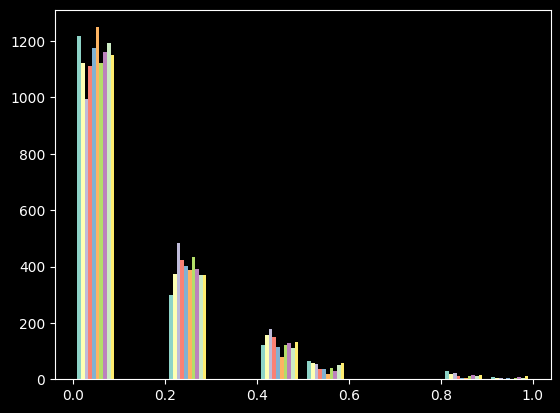

In [48]:
knn_model = KNeighborsClassifier(n_neighbors=5)
acc, conf = self_train_model(knn_model, X_train_labeled, y_train_labeled, X_train_unlabeled, X_val, y_val)

print(acc)

plt.hist(conf)
plt.show()

### GNB

0.22337363270005758


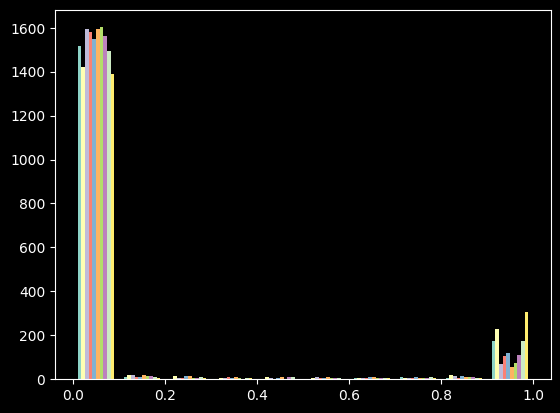

In [49]:
gnb_model = GaussianNB()
acc, conf = self_train_model(gnb_model, X_train_labeled, y_train_labeled, X_train_unlabeled, X_val, y_val)

print(acc)

plt.hist(conf)
plt.show()

### BNB

0.21646516983304548


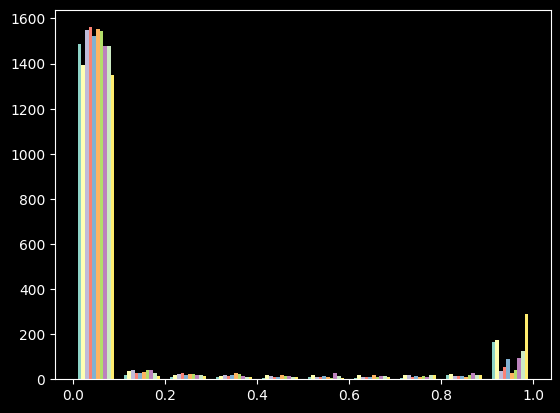

In [50]:
bnb_model = BernoulliNB()
acc, conf = self_train_model(bnb_model, X_train_labeled, y_train_labeled, X_train_unlabeled, X_val, y_val)

print(acc)

plt.hist(conf)
plt.show()

### AdaBoost

0.1980426021876799


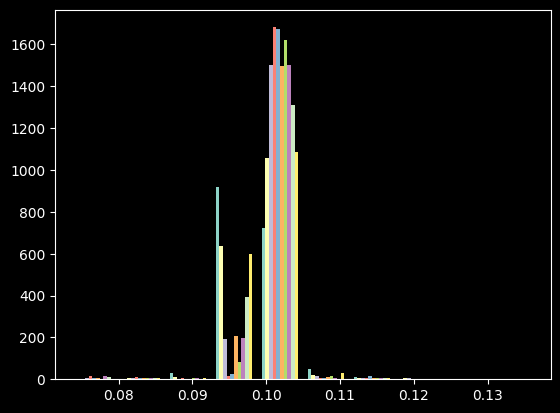

In [51]:
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=0)
acc, conf = self_train_model(adaboost_model, X_train_labeled, y_train_labeled, X_train_unlabeled, X_val, y_val)

print(acc)

plt.hist(conf)
plt.show()

### DT

0.14680483592400692


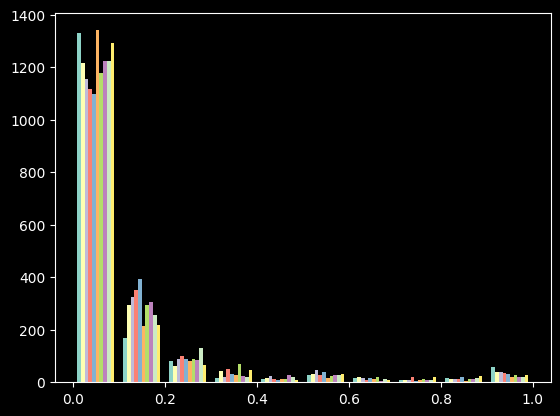

In [52]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_leaf=2, min_samples_split=10, splitter='random')

acc, confidence = self_train_model(dt_model, X_train_labeled, y_train_labeled, X_train_unlabeled, X_val, y_val)
print(acc)

# plot the confidence
plt.hist(confidence)
plt.show()

### Adaboost + DT

0.2141623488773748


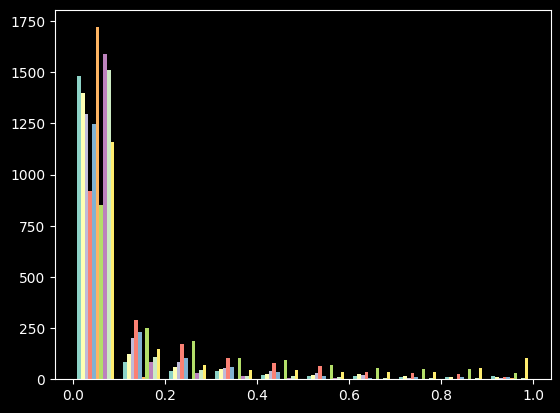

In [53]:
adaboost_dt_model = AdaBoostClassifier(base_estimator=dt_model, n_estimators=100, random_state=0)
acc, confidence = self_train_model(adaboost_dt_model, X_train_labeled, y_train_labeled, X_train_unlabeled, X_val, y_val)

print(acc)

plt.hist(confidence)
plt.show()

### GNB + Adaboost

0.1381692573402418


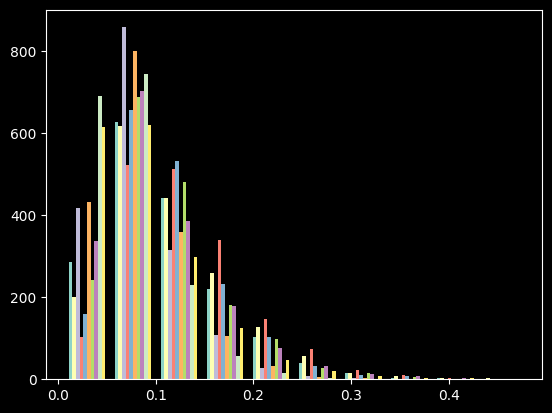

In [54]:
adaboost_gnb_model = AdaBoostClassifier(base_estimator=gnb_model, n_estimators=100, random_state=0)
acc, confidence = self_train_model(adaboost_gnb_model, X_train_labeled, y_train_labeled, X_train_unlabeled, X_val, y_val)

print(acc)

plt.hist(confidence)
plt.show()

### BNB + Adaboost

0.1491076568796776


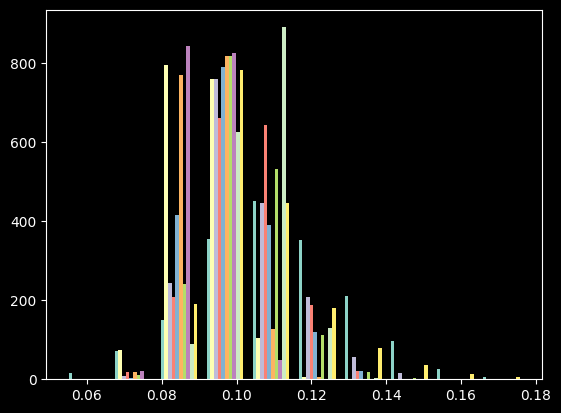

In [55]:
adaboost_bnb_model = AdaBoostClassifier(base_estimator=bnb_model, n_estimators=100, random_state=0)
acc, confidence = self_train_model(adaboost_bnb_model, X_train_labeled, y_train_labeled, X_train_unlabeled, X_val, y_val)

print(acc)

plt.hist(confidence)
plt.show()


### SVM

0.24640184225676454


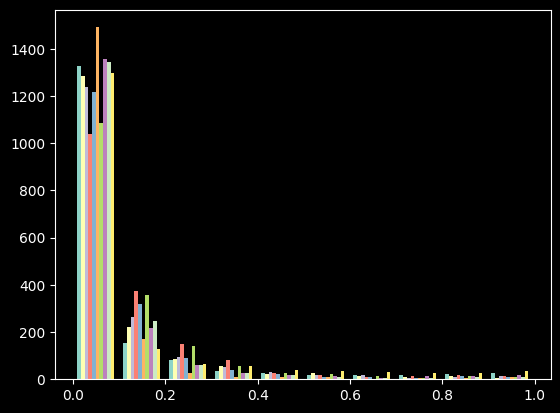

In [58]:
svm_model = SVC(C=2, kernel='poly', probability=True)
acc, confidence = self_train_model(svm_model, X_train_labeled, y_train_labeled, X_train_unlabeled, X_val, y_val)

print(acc)

plt.hist(confidence)
plt.show()

## Submit

In [19]:
clf = SVC(kernel='poly', C=2.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(test_emb_data)

In [21]:
y_pred = pd.DataFrame(y_pred).astype(int)

In [22]:
test_raw_data['salary_bin'] = y_pred

In [23]:
test_raw_data.head()

,job_id,requirements_and_role,gender_code,salary_bin
0,JOB-2019-0016087,7am 1pm 1pm 7pm part time 5 day work week satu...,0,0
1,JOB-2019-0008055,legal counsel function corporate generalist pr...,0,9
2,JOB-2019-0001658,responsibilities manage various types engineer...,1,2
3,JOB-2019-0016777,passionate technologists believe power softwar...,2,7
4,JOB-2019-0017600,looking process analyst permanent stable oppor...,2,6


In [24]:
# get job_id and salary_bin to csv

# test_raw_data[['job_id', 'salary_bin']].to_csv('test_salaries.csv', index=False)